# UMAP Classifier Tutorial for Large Datasets

UMAP and the attached prediction methods can get very memory consuming for large datasets. In this tutorial, we present solutions to that problem. If you haven't yet, consider taking a look at the [UMAP Classifier Tutorial](umap_classifier.ipynb).

In [4]:
# import modules
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
from helper_scripts import random_rm_trace_generator
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
import importlib
from matplotlib import pyplot as plt
from modules import umap_classifier
from modules import performance_metrics as pm
import joblib
import os
%load_ext memory_profiler

/cr/work/kastner/miniconda3/envs/aera01/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-01 14:18:52.159013: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-01 14:18:52.199704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756729132.221761 1231122 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756729132.228213 1231122 cuda_blas

> Often, unfiltered monitoring datasets contain lots of "normal" events, which are not very interesting for the overall analysis and a few interesting events. Furthermore, they might be stored in separate files. Here, we present a method of loading the data from the files and filtering them with UMAP and DBSCAN/HDBSCAN on the go in order to maximize the Shannon entropy among the predicted cluster labels of the selected events. However, since this can be either very time or memory expensive, the prefered method should always be to filter the given datasets in advance. If the normal behavior is already known, this can be done for example by introducing likelihood cuts to preselect conspicious events.

In [2]:
%%memit
# Attention: this consumesupt to 2.55 GB of RAM
# Before running the script we generate 50,000 random RM traces in 5 files, containing mostly events from from a class representing normal behavior,
# a smaller number of events from 8 other classes representing different types of malfunctions
# and a few outlier traces, which do not belong to any of the classes.
if not os.path.exists("../data/large_dataset_1/batch_0.pkl"):
    os.makedirs("../data/large_dataset_1", exist_ok=True)
    time_traces, _, _, true_clusters, _,_=random_rm_trace_generator.generate_random_rm_traces(
        40000, n_clusters=1, outlier_fraction=0, noise_level=1)
    time_traces2, _, _, true_clusters2, _,_=random_rm_trace_generator.generate_random_rm_traces(
        10000, n_clusters=8, outlier_fraction=0.1, noise_level=1)
    true_clusters2[true_clusters2==0]=8
    time_traces = np.concatenate((time_traces, time_traces2), axis=0)
    true_clusters = np.concatenate((true_clusters, true_clusters2), axis=0)
    indices = np.random.choice(np.arange(50000), size=50000, replace=False)
    for i in range(5):
        df = pd.DataFrame(columns=["time_trace", "true_cluster"])
        df["time_trace"]=list(time_traces[indices[i*10000:(i+1)*10000]])
        df["true_cluster"]=list(true_clusters[indices[i*10000:(i+1)*10000]])
        joblib.dump(df, f"../data/large_dataset_1/batch_{i}.pkl")
    del time_traces, time_traces2, true_clusters, true_clusters2, df, indices

peak memory: 1133.15 MiB, increment: 0.23 MiB


In [3]:
# first define a custom data loader function, which loads the data from a given file path
# this function has to return the data and interesting properties (either None or np.array(batch_size, n_properties)) 
# that shall be kept for later analysis
# in this case, we want to keep the true cluster information for later performance evaluation

def custom_data_loader(file_path):
    df = joblib.load(file_path)
    return np.stack(df["time_trace"].to_numpy()), np.array([df["true_cluster"].to_numpy()]).T

In [ ]:
%%capture output
# Load data batch-wise from directory and select interesting events
dir_path = '../data/large_dataset_1'
u_clas = umap_classifier.UMAPClassifier(yaml_path="../yaml_files/umap_classifier_test.yaml", input_data_type="time")
_, selected_raw_data, selected_properties = u_clas.load_umap_data_from_dir(dir_path, 
                            data_loader=custom_data_loader, # custom data loader function
                            clustering_mode="hdbscan", # clustering mode can be "dbscan" or "hdbscan"
                            max_umap_events=2000, # maximum number of events for the final the UMAP model
                            batch_size=5000, # number of events to be loaded and processed at once
                            n_selected_per_batch=1000, # number of interesting events to be selected from each batch
                            summary_batch_size=3000, # number of events after which the current best data selection is updated
                            return_raw = True, # also return the raw data
                            verbose=False)

In [7]:
# the data is returned in RAM efficient memory-mapped numpy arrays
print("Selected data type:",type(selected_raw_data))
print("Selected data shape:",selected_raw_data.shape)
print("Selected properties type:",type(selected_properties))
print("Selected properties shape:",selected_properties.shape if selected_properties is not None else None)

Selected data type: <class 'numpy.memmap'>
Selected data shape: (2000, 1024)
Selected properties type: <class 'numpy.memmap'>
Selected properties shape: (2000, 1)


In [8]:
# The identified interesting events are
# As one can see, many of the noise events (true_cluster = -1) are selected.
# The other clusters are approximately uniformly distributed
np.unique(selected_properties,return_counts=True) 

(array([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=object),
 array([725, 135, 132, 163, 170, 134, 136, 135, 135, 135]))

**Load data batch-wise**
> For the case if reading the files already delivers huge datasets, we also offer an opportunitiy to already load the dta batch-wise from the files.

In [5]:
# Create a custom data batch loader function which just loads a certain batch of data from a given file path
# This function has to return the data batch, the interesting properties and a boolean variable indicating if
# the last batch from the corresponding file has been reached (True if last batch, False otherwise)
batch_size = 5000
def custom_data_batch_loader(batch_idx,file_path):
    df = joblib.load(file_path)
    i_min = batch_idx*batch_size
    i_max = min((batch_idx+1)*batch_size, len(df))
    if i_max >= len(df):
        return np.stack(df["time_trace"].to_numpy())[i_min:i_max], np.array([df["true_cluster"].to_numpy()]).T[i_min:i_max], True
    else:
        return np.stack(df["time_trace"].to_numpy())[i_min:i_max], np.array([df["true_cluster"].to_numpy()]).T[i_min:i_max], False

In [9]:
%%capture output

# Load data batch-wise from directory and select interesting events
dir_path = '../data/large_dataset_1'
u_clas = umap_classifier.UMAPClassifier(yaml_path="../yaml_files/umap_classifier_test.yaml", input_data_type="time")
selected_data, selected_properties = u_clas.load_umap_data_batchwise_from_dir(dir_path, 
                            data_batch_loader=custom_data_batch_loader,
                            clustering_mode="dbscan",
                            max_umap_events=3000,
                            batch_size=5000,
                            summary_batch_size=3000,
                            n_selected_per_batch=1000,
                            return_raw=False,   
                            verbose=False)

In [10]:
# the data is returned in RAM efficient memory-mapped numpy arrays
print("Selected data type:",type(selected_data))
print("Selected data shape:",selected_data.shape)
print("Selected properties type:",type(selected_properties))
print("Selected properties shape:",selected_properties.shape if selected_properties is not None else None)

Selected data type: <class 'numpy.memmap'>
Selected data shape: (3000, 512)
Selected properties type: <class 'numpy.memmap'>
Selected properties shape: (3000, 1)


In [11]:
# The identified interesting events are
# As one can see, many of the noise events (true_cluster = -1) are selected.
# The other clusters are approximately uniformly distributed
np.unique(selected_properties, return_counts=True)

(array([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=object),
 array([681, 265, 260, 249, 256, 254, 255, 261, 257, 262]))

> Subsequently, the filtered dataset can be processed as any other prepared dataset

In [13]:
%%capture output
# Create UMAP embeddings
embeddings=u_clas.embed(selected_data)


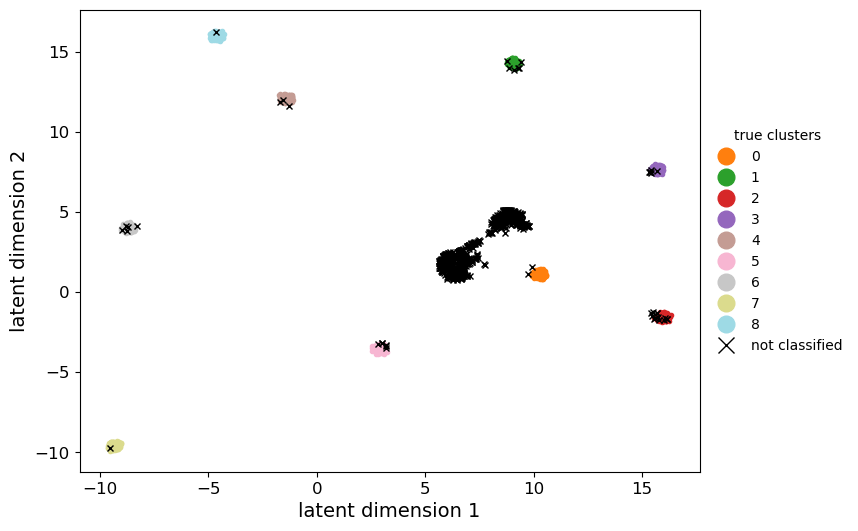

In [ ]:
# plot the embeddings with true cluster labels
fig, ax = u_clas.plot_embedding(embeddings, labels=selected_properties.flatten(), label_type='categorical', label_name="true clusters", alpha=1)

Overriding db_min_samples with value 50 from kwargs.
Overriding db_eps with value 0.2 from kwargs.


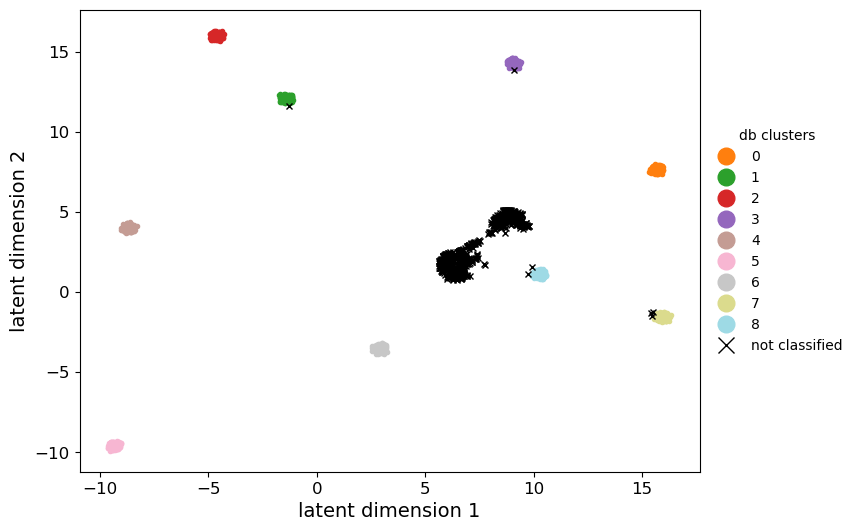

In [24]:
# Using DBSCAN for clustering
# Then plot the embeddings with the identified DBSCAN clusters
db_clusters=u_clas.db_classify(embeddings, db_min_samples=50, db_eps=0.2)
fig, ax = u_clas.plot_embedding(embeddings, labels=db_clusters, label_type='categorical', label_name="db clusters", alpha=1)

> We see, that the outliers also form clusters, which are less dense than the others. Further structure might be found by using just the data from the not dense clusters as inout for a new clustering process.